# Packages Import

In [869]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing.label import _encode
from sklearn.utils import column_or_1d
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from textblob import TextBlob
from string import punctuation
import unidecode
from empath import Empath
from xgboost import XGBClassifier
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

## Data Extraction 


In [870]:
df_train = pd.read_table('https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/train2.tsv', sep = '\t')
df_test = pd.read_table('https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/test2.tsv', sep = '\t')
df_val = pd.read_table('https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/val2.tsv', sep = '\t')

#Labeling columns:
df_train.columns = ['index', 'json_nbr', 'label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification']
df_test.columns = ['index', 'json_nbr', 'label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification']
df_val.columns = ['index', 'json_nbr', 'label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification']

C:\Users\manav\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
C:\Users\manav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
C:\Users\manav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


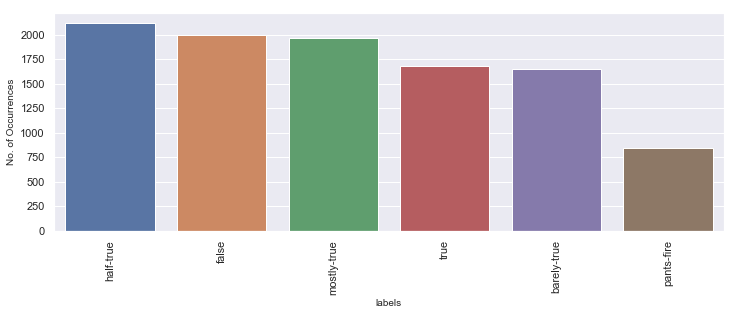

In [871]:
##Visiualizing the prediction column

count = df_train['label'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(count.index, count.values, alpha=1)
plt.ylabel('No. of Occurrences', fontsize=10)
plt.xlabel('labels', fontsize=10)
plt.xticks(rotation=90)
plt.show()

## Data Cleaning

In [872]:
## Data Cleaning ##
df_train = df_train.drop(['index', 'json_nbr'], axis=1)
df_test = df_test.drop(['index', 'json_nbr'], axis=1)
df_val = df_val.drop(['index', 'json_nbr'], axis=1)


for col in ['news', 'topic', 'name', 'dsgntn', 'province', 'party', 'source', 'justification']:
    df_train[col] = df_train[col].str.lower()
    df_test[col] = df_test[col].str.lower()
    df_val[col] = df_val[col].str.lower()
    
    def unidecode_text(text):
        try:
            text = unidecode.unidecode(text)
        except:
            pass
        return text
    df_train[col] = df_train.apply(lambda row: unidecode_text(row[col]), axis=1)
    df_test[col] = df_test.apply(lambda row: unidecode_text(row[col]), axis=1)
    df_val[col] = df_val.apply(lambda row: unidecode_text(row[col]), axis=1)

In [873]:
## Dropping datapoints with Null values ## 
df_train = df_train.dropna(subset=['label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification'])
df_test = df_test.dropna(subset=['label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification'])
df_val = df_val.dropna(subset=['label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification'])

In [874]:
## Reseting index so as to avoid any confusion while mapping

df_train = df_train.reset_index()
df_train.drop('index', axis=1, inplace = True)

df_test = df_test.reset_index()
df_test.drop('index', axis=1, inplace = True)

df_val = df_val.reset_index()
df_val.drop('index', axis=1, inplace = True)

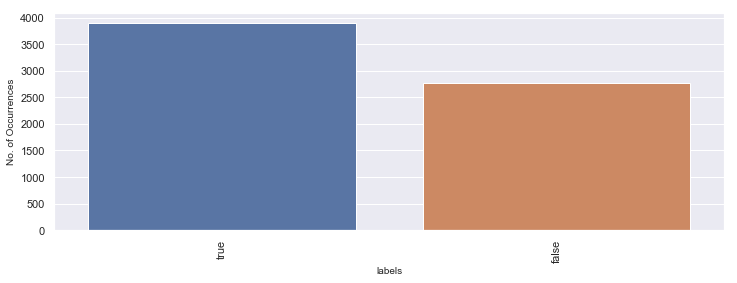

In [875]:
## Adding Binary Label ##

## Training
df_true_1 = df_train[df_train['label'] == 'half-true']
df_true_2 = df_train[df_train['label'] == 'mostly-true']
df_true_3 = df_train[df_train['label'] == 'true']
df_true = pd.concat([df_true_1, df_true_2, df_true_3])
df_true['label_bin'] = ['true']*df_true.shape[0]

df_false_1 = df_train[df_train['label'] == 'barely-true']
df_false_2 = df_train[df_train['label'] == 'pants-fire']
df_false_3 = df_train[df_train['label'] == 'false']
df_false = pd.concat([df_false_1, df_false_2, df_false_3])
df_false['label_bin'] = ['false']*df_false.shape[0]

df_train = pd.concat([df_true, df_false]).sample(frac=1)

## Testing
df_true_1 = df_test[df_test['label'] == 'half-true']
df_true_2 = df_test[df_test['label'] == 'mostly-true']
df_true_3 = df_test[df_test['label'] == 'true']
df_true = pd.concat([df_true_1, df_true_2, df_true_3])
df_true['label_bin'] = ['true']*df_true.shape[0]

df_false_1 = df_test[df_test['label'] == 'barely-true']
df_false_2 = df_test[df_test['label'] == 'pants-fire']
df_false_3 = df_test[df_test['label'] == 'false']
df_false = pd.concat([df_false_1, df_false_2, df_false_3])
df_false['label_bin'] = ['false']*df_false.shape[0]

df_test = pd.concat([df_true, df_false]).sample(frac=1)

## Validation
df_true_1 = df_val[df_val['label'] == 'half-true']
df_true_2 = df_val[df_val['label'] == 'mostly-true']
df_true_3 = df_val[df_val['label'] == 'true']
df_true = pd.concat([df_true_1, df_true_2, df_true_3])
df_true['label_bin'] = ['true']*df_true.shape[0]

df_false_1 = df_val[df_val['label'] == 'barely-true']
df_false_2 = df_val[df_val['label'] == 'pants-fire']
df_false_3 = df_val[df_val['label'] == 'false']
df_false = pd.concat([df_false_1, df_false_2, df_false_3])
df_false['label_bin'] = ['false']*df_false.shape[0]

df_val = pd.concat([df_true, df_false]).sample(frac=1)


##Visiualizing the prediction column

count = df_train['label_bin'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(count.index, count.values, alpha=1)
plt.ylabel('No. of Occurrences', fontsize=10)
plt.xlabel('labels', fontsize=10)
plt.xticks(rotation=90)
plt.show()

In [877]:
## Size Description ##
print('Size of Cleaned Training Data: ', df_train.shape)
print('Size of Cleaned Testing Data: ', df_test.shape)
print('Size of Cleaned Validation Data: ', df_val.shape)

Size of Cleaned Training Data:  (6668, 15)
Size of Cleaned Testing Data:  (848, 15)
Size of Cleaned Validation Data:  (857, 15)


# PART 1: LogisticRegression & LSTMs

## Data Preprocessing

In [879]:
## Sentiment Analysis using TextBlob ##
# TextBlob rates the sentiments of any text on two metrics: polarity & subjectivity

def senti(x):
    return TextBlob(x).sentiment  

# For Training Data
df_train['senti_score'] = df_train['news'].apply(senti)
df_senti = pd.DataFrame(df_train['senti_score'].values.tolist(), columns=['senti_score_polarity','senti_score_subjectivity'])
df_train = pd.concat([df_train, df_senti], axis=1)
df_train.drop('senti_score', axis=1, inplace=True)

# For Testing Data
df_test['senti_score'] = df_test['news'].apply(senti)
df_senti = pd.DataFrame(df_test['senti_score'].values.tolist(), columns=['senti_score_polarity','senti_score_subjectivity'])
df_test = pd.concat([df_test, df_senti], axis=1)
df_test.drop('senti_score', axis=1, inplace=True)

# For Validation Data
df_val['senti_score'] = df_val['news'].apply(senti)
df_senti = pd.DataFrame(df_val['senti_score'].values.tolist(), columns=['senti_score_polarity','senti_score_subjectivity'])
df_val = pd.concat([df_val, df_senti], axis=1)
df_val.drop('senti_score', axis=1, inplace=True)

## Emotion Analysis

In [880]:
## Emotion Analysis using Empath ##
# I considered 34 emotions for this analysis, the list of which is given below

emotions = ["violence", 'hate', 'cheerfulness', 'aggregation', 'envy', 'anticipation', 'pride', 'weakness', 'horror', 'swearing_terms', 'suffering', 'fear', 'childish', 'exasperation', 'confusion', 'heroic', 'celebration', 'ridicule', 'neglect', 'sympathy', 'deception', 'politeness', 'disgust', 'rage', 'optimism', 'sadness', 'joy', 'lust', 'shame', 'strength', 'power', 'pain', 'disappointment', 'positive_emotion']
df_emo = pd.DataFrame(np.zeros([df_train.shape[0], 34]), columns = emotions)


lexicon = Empath()

# For Training Data
n = 0
for i in df_train['news']:
    dic = lexicon.analyze(i, categories= emotions, normalize=True)
    keys = list(dic.keys())
    for m in keys:
        df_emo[m][n] = dic[m]
    n = n+1
# Concatenating the data
df_train = pd.concat([df_train, df_emo], axis=1)

# For Testing Data
n = 0
for i in df_test['news']:
    dic = lexicon.analyze(i, categories= emotions, normalize=True)
    keys = list(dic.keys())
    for m in keys:
        df_emo[m][n] = dic[m]
    n = n+1
# Concatenating the data
df_test = pd.concat([df_test, df_emo], axis=1)

# For Validation Data
n = 0
for i in df_val['news']:
    dic = lexicon.analyze(i, categories= emotions, normalize=True)
    keys = list(dic.keys())
    for m in keys:
        df_emo[m][n] = dic[m]
    n = n+1
# Concatenating the data
df_val = pd.concat([df_val, df_emo], axis=1)

## STEMMING 

In [881]:
## STEMMING ##

st = PorterStemmer()

for col in ['news', 'topic', 'name', 'dsgntn', 'province', 'party', 'source', 'justification']:
    df_train[col] = df_train[col].astype(str)
    df_test[col] = df_test[col].astype(str)
    df_val[col] = df_val[col].astype(str)
    df_train[col] = df_train[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    df_test[col] = df_test[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    df_val[col] = df_val[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))


## STOPWORDS

In [882]:
## STOPWORDS ##

stop = stopwords.words('english')

for col in ['news', 'topic', 'name', 'dsgntn', 'province', 'party', 'source', 'justification']:
    df_train[col] = df_train[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    df_test[col] = df_test[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    df_val[col] = df_val[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## Count Vectorization

In [883]:
## Count Vectorization ##

# creating a count vectorizer
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')

list_counts_train = []
list_counts_test = []
for col in ['news', 'topic', 'name', 'dsgntn', 'province', 'party', 'source', 'justification']:
   
    count_vect.fit(df_train[col])

    # transforming the training and testing data using count vectorizer object
    xtrain_count =  count_vect.transform(df_train[col])
    xtest_count =  count_vect.transform(df_test[col])
    list_counts_train.append(xtrain_count.todense())
    list_counts_test.append(xtest_count.todense())

In [884]:
## remove punctuation

df_train['concat_text'] = (df_train["news"]+ " " + df_train["topic"] + " " + df_train["name"]+ " " + df_train["dsgntn"] + " " + df_train["province"]+ " " + df_train["source"]+ " " + df_train["justification"])
df_test['concat_text'] = (df_test["news"]+ " " + df_test["topic"] + " " + df_test["name"]+ " " + df_test["dsgntn"] + " " + df_test["province"]+ " " + df_test["source"]+ " " + df_test["justification"])
df_val['concat_text'] = (df_val["news"]+ " " + df_val["topic"] + " " + df_val["name"]+ " " + df_val["dsgntn"] + " " + df_val["province"]+ " " + df_val["source"]+ " " + df_val["justification"])

df_train['concat_text'] = df_train['concat_text'].str.replace('[^\w\s]','')
df_test['concat_text'] = df_test['concat_text'].str.replace('[^\w\s]','')
df_val['concat_text'] = df_val['concat_text'].str.replace('[^\w\s]','')

## Tf Idf Vectorizer

In [885]:
## Tf Idf Vectorizer ##

# word level tf-idf
# I also tried tf-idf with n-grams (2&3), but unigram produces the best results

# df_train['concat_text'] = (df_train["news"]+ " " + df_train["topic"] + " " + df_train["name"]+ " " + df_train["dsgntn"] + " " + df_train["province"]+ " " + df_train["source"]+ " " + df_train["justification"])
# df_test['concat_text'] = (df_test["news"]+ " " + df_test["topic"] + " " + df_test["name"]+ " " + df_test["dsgntn"] + " " + df_test["province"]+ " " + df_test["source"]+ " " + df_test["justification"])
# df_val['concat_text'] = (df_val["news"]+ " " + df_val["topic"] + " " + df_val["name"]+ " " + df_val["dsgntn"] + " " + df_val["province"]+ " " + df_val["source"]+ " " + df_val["justification"])


tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=7000)
# We are using the best 7000 extracted features so as to avoid noise & enhance accuracy 
df_train = df_train.dropna()
df_test = df_test.dropna()
df_val = df_val.dropna()
tfidf_vect.fit(df_train['concat_text'])
xtrain_tfidf =  tfidf_vect.transform(df_train['concat_text'])
tfidf_vect.fit(df_test['concat_text'])
xtest_tfidf =  tfidf_vect.transform(df_test['concat_text'])
tfidf_vect.fit(df_val['concat_text'])
xval_tfidf =  tfidf_vect.transform(df_test['concat_text'])

df_train = pd.concat([df_train, pd.DataFrame(xtrain_tfidf.todense())], axis=1)
df_test = pd.concat([df_test, pd.DataFrame(xtest_tfidf.todense())], axis=1)
df_val = pd.concat([df_val, pd.DataFrame(xval_tfidf.todense())], axis=1)

In [887]:
## Preparing Model ready input data ##

df_train.drop(['concat_text', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'source', 'justification'], axis=1, inplace=True)
df_test.drop(['concat_text', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'source', 'justification'], axis=1, inplace=True)
df_val.drop(['concat_text', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'source', 'justification'], axis=1, inplace=True)

## Training & Testing the Model: Logistic Regression

In [888]:
df_val = df_val.dropna()

X_train = df_train.drop(['label', 'label_bin'], axis=1)
X_test = df_test.drop(['label', 'label_bin'], axis=1)
X_val = df_val.drop(['label', 'label_bin'], axis=1)

y_train = df_train['label']
y_test = df_test['label']
y_val = df_val['label']

y_bin_train = df_train['label_bin']
y_bin_test = df_test['label_bin']
y_bin_val =df_val['label_bin']

In [810]:
## Training the Model: Logistic Regression ##

clf_six = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)
clf_bin = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_bin_train)

df_test = df_test.dropna()

C:\Users\manav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\manav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Visualising Results of Test Dataset: Six Way Classification

Accuracy: 0.29952830188679247
Precision: 0.29952830188679247
              precision    recall  f1-score   support

 barely-true       0.24      0.07      0.11       139
       false       0.33      0.28      0.31       167
   half-true       0.28      0.62      0.39       181
 mostly-true       0.31      0.47      0.38       173
  pants-fire       0.43      0.07      0.12        42
        true       0.00      0.00      0.00       146

   micro avg       0.30      0.30      0.30       848
   macro avg       0.27      0.25      0.22       848
weighted avg       0.25      0.30      0.24       848

Confusion matrix:


C:\Users\manav\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\manav\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\manav\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


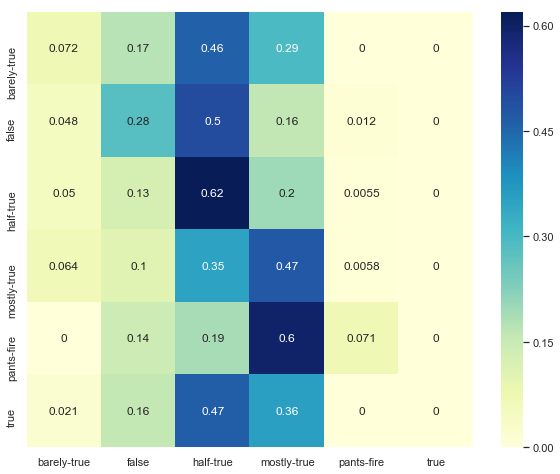

In [811]:
y_pred = clf_six.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average = 'micro'))
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
cm=metrics.confusion_matrix(y_test, y_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(cm, 
    xticklabels=clf_six.classes_,
    yticklabels=clf_six.classes_,
       annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

## Visualising Results of Validation Dataset: Six Way Classification

Accuracy: 0.31839622641509435
Precision: 0.31839622641509435
              precision    recall  f1-score   support

 barely-true       0.31      0.10      0.15       151
       false       0.36      0.28      0.31       173
   half-true       0.28      0.64      0.39       169
 mostly-true       0.36      0.56      0.44       172
  pants-fire       0.29      0.03      0.06        59
        true       0.00      0.00      0.00       124

   micro avg       0.32      0.32      0.32       848
   macro avg       0.27      0.27      0.22       848
weighted avg       0.28      0.32      0.26       848

Confusion matrix:


C:\Users\manav\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\manav\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\manav\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


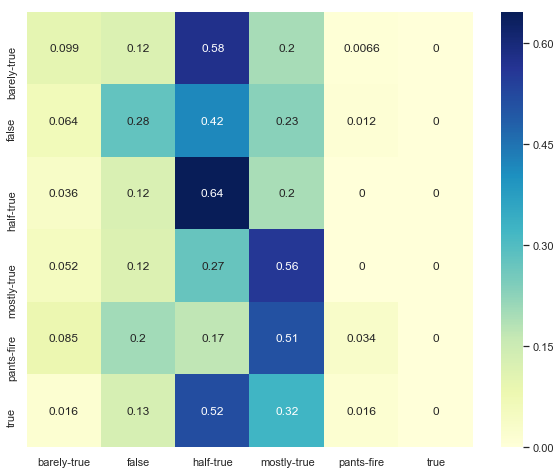

In [816]:
y_val_pred = clf_six.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, average = 'micro'))
print(classification_report(y_val, y_val_pred))
print('Confusion matrix:')
cm=metrics.confusion_matrix(y_val, y_val_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(cm, 
    xticklabels=clf_six.classes_,
    yticklabels=clf_six.classes_,
       annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

## Visualising Results of Test Dataset: Binary Classification

Accuracy: 0.5742924528301887
Precision: 0.5742924528301887
              precision    recall  f1-score   support

       false       0.48      0.47      0.47       348
        true       0.64      0.65      0.64       500

   micro avg       0.57      0.57      0.57       848
   macro avg       0.56      0.56      0.56       848
weighted avg       0.57      0.57      0.57       848

Confusion matrix:


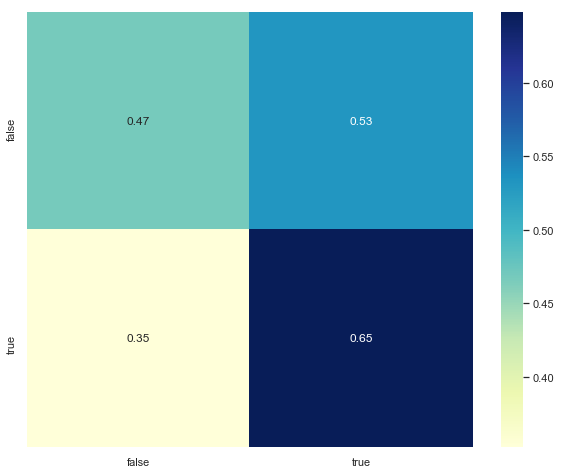

In [813]:
y_pred = clf_bin.predict(X_test)

print("Accuracy:", accuracy_score(y_bin_test, y_pred))
print("Precision:", precision_score(y_bin_test, y_pred, average = 'micro'))
print(classification_report(y_bin_test, y_pred))
print('Confusion matrix:')
cm=metrics.confusion_matrix(y_bin_test, y_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(cm, 
    xticklabels=clf_bin.classes_,
    yticklabels=clf_bin.classes_,
       annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

## Visualising Results of Validation Dataset: Binary Classification

Accuracy: 0.5884433962264151
Precision: 0.5884433962264151
              precision    recall  f1-score   support

       false       0.55      0.50      0.52       383
        true       0.62      0.66      0.64       465

   micro avg       0.59      0.59      0.59       848
   macro avg       0.58      0.58      0.58       848
weighted avg       0.59      0.59      0.59       848

Confusion matrix:


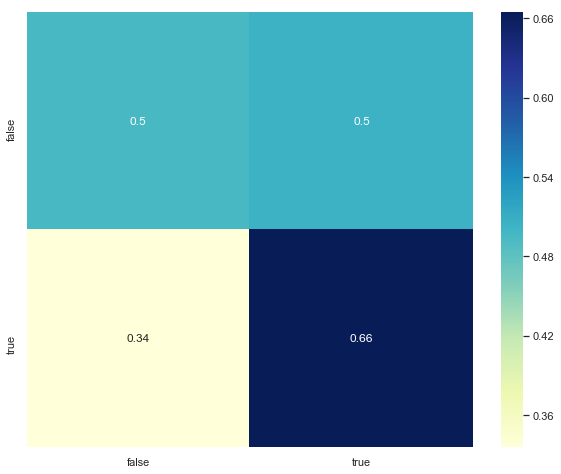

In [815]:
y_val_pred = clf_bin.predict(X_val)

print("Accuracy:", accuracy_score(y_bin_val, y_val_pred))
print("Precision:", precision_score(y_bin_val, y_val_pred, average = 'micro'))
print(classification_report(y_bin_val, y_val_pred))
print('Confusion matrix:')
cm=metrics.confusion_matrix(y_bin_val, y_val_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(cm, 
    xticklabels=clf_bin.classes_,
    yticklabels=clf_bin.classes_,
       annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

## Using LSTMs

In [891]:
max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
# Encoding Training Labels
y_train = column_or_1d(y_train, warn=True)
classes_,encoded_values = _encode(y_train,uniques=np.array(['half-true', 'mostly-true', 'false', 'true', 'barely-true','pants-fire']),encode=True)
encoded_values, classes_
y_train = encoded_values

# Encoding Testing Labels
y_test = column_or_1d(y_test, warn=True)
classes_,encoded_values = _encode(y_test,uniques=np.array(['half-true', 'mostly-true', 'false', 'true', 'barely-true','pants-fire']),encode=True)
encoded_values, classes_
y_test = encoded_values

# Encoding Validation Labels
y_val = column_or_1d(y_val, warn=True)
classes_,encoded_values = _encode(y_val,uniques=np.array(['half-true', 'mostly-true', 'false', 'true', 'barely-true','pants-fire']),encode=True)
encoded_values, classes_
y_val = encoded_values


print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(np.array(X_train), maxlen=maxlen)
x_test = sequence.pad_sequences(np.array(X_test), maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Training...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[x_test, y_test])

Loading data...
6668 train sequences
848 test sequences
Pad sequences (samples x time)
x_train shape: (6668, 100)
x_test shape: (848, 100)
Training...
Train on 6668 samples, validate on 848 samples
Epoch 1/4
6668/6668 [==============================] - 31s 5ms/step - loss: -14.8128 - acc: 0.2035 - val_loss: -16.2244 - val_acc: 0.2040
Epoch 2/4
6668/6668 [==============================] - 27s 4ms/step - loss: -16.8419 - acc: 0.2034 - val_loss: -16.2244 - val_acc: 0.2040
Epoch 3/4
6668/6668 [==============================] - 26s 4ms/step - loss: -16.8437 - acc: 0.2034 - val_loss: -16.2244 - val_acc: 0.2040
Epoch 4/4
6668/6668 [==============================] - 27s 4ms/step - loss: -16.8431 - acc: 0.2034 - val_loss: -16.2244 - val_acc: 0.2040


In [892]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

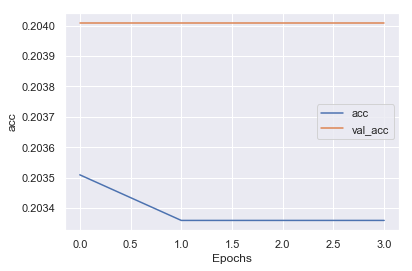

In [893]:
plot_graphs(history, 'acc')

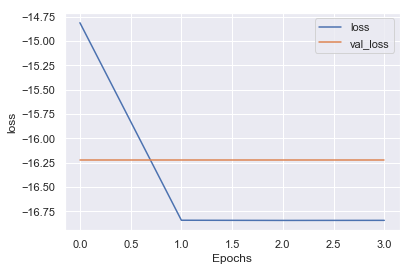

In [894]:
plot_graphs(history, 'loss')

## So this was the end of part one. 
## Let's move to part two where XGBoost has been used to deliver the best results

# PART 2: XGBoost with tuned Hyperparameter

In [817]:
df_train = pd.read_table('https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/train2.tsv', sep = '\t')
df_test = pd.read_table('https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/test2.tsv', sep = '\t')
df_val = pd.read_table('https://raw.githubusercontent.com/Tariq60/LIAR-PLUS/master/dataset/val2.tsv', sep = '\t')

#Labeling columns:
df_train.columns = ['index', 'json_nbr', 'label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification']
df_test.columns = ['index', 'json_nbr', 'label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification']
df_val.columns = ['index', 'json_nbr', 'label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification']

C:\Users\manav\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
C:\Users\manav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
C:\Users\manav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


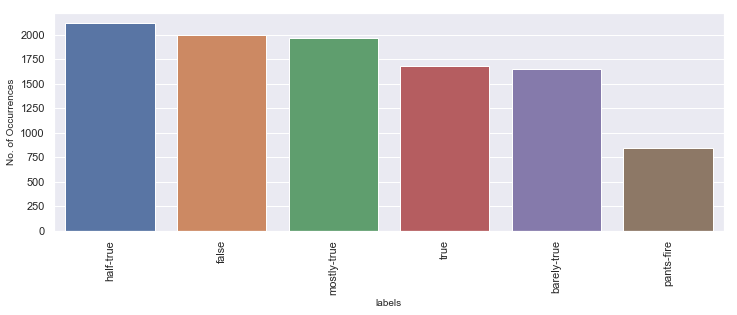

In [818]:
##Visiualizing the prediction column: Six Way

count = df_train['label'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(count.index, count.values, alpha=1)
plt.ylabel('No. of Occurrences', fontsize=10)
plt.xlabel('labels', fontsize=10)
plt.xticks(rotation=90)
plt.show()

In [819]:
## Data Cleaning ##
df_train = df_train.drop(['index', 'json_nbr'], axis=1)
df_test = df_test.drop(['index', 'json_nbr'], axis=1)
df_val = df_val.drop(['index', 'json_nbr'], axis=1)
for col in ['news', 'topic', 'name', 'dsgntn', 'province', 'party', 'source', 'justification']:
    df_train[col] = df_train[col].str.lower()
    df_test[col] = df_test[col].str.lower()
    df_val[col] = df_val[col].str.lower()
    
    def unidecode_text(text):
        try:
            text = unidecode.unidecode(text)
        except:
            pass
        return text
    df_train[col] = df_train.apply(lambda row: unidecode_text(row[col]), axis=1)
    df_test[col] = df_test.apply(lambda row: unidecode_text(row[col]), axis=1)
    df_val[col] = df_val.apply(lambda row: unidecode_text(row[col]), axis=1)

In [820]:
## Dropping datapoints with Null values ## 
df_train = df_train.dropna(subset=['label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification'])
df_test = df_test.dropna(subset=['label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification'])
df_val = df_val.dropna(subset=['label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1', 'n2', 'n3', 'n4', 'n5', 'source', 'justification'])

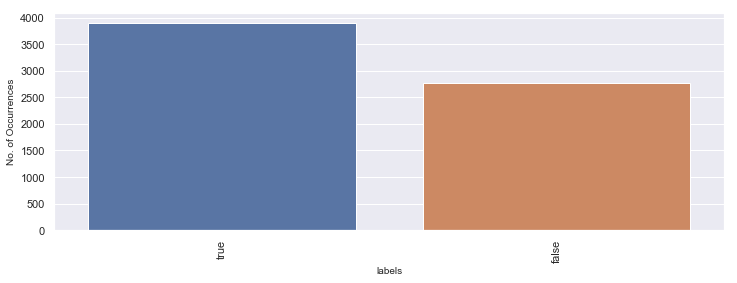

In [821]:
## Adding Binary Label ##

## Training
df_true_1 = df_train[df_train['label'] == 'half-true']
df_true_2 = df_train[df_train['label'] == 'mostly-true']
df_true_3 = df_train[df_train['label'] == 'true']
df_true = pd.concat([df_true_1, df_true_2, df_true_3])
df_true['label_bin'] = ['true']*df_true.shape[0]

df_false_1 = df_train[df_train['label'] == 'barely-true']
df_false_2 = df_train[df_train['label'] == 'pants-fire']
df_false_3 = df_train[df_train['label'] == 'false']
df_false = pd.concat([df_false_1, df_false_2, df_false_3])
df_false['label_bin'] = ['false']*df_false.shape[0]

df_train = pd.concat([df_true, df_false]).sample(frac=1)

## Testing
df_true_1 = df_test[df_test['label'] == 'half-true']
df_true_2 = df_test[df_test['label'] == 'mostly-true']
df_true_3 = df_test[df_test['label'] == 'true']
df_true = pd.concat([df_true_1, df_true_2, df_true_3])
df_true['label_bin'] = ['true']*df_true.shape[0]

df_false_1 = df_test[df_test['label'] == 'barely-true']
df_false_2 = df_test[df_test['label'] == 'pants-fire']
df_false_3 = df_test[df_test['label'] == 'false']
df_false = pd.concat([df_false_1, df_false_2, df_false_3])
df_false['label_bin'] = ['false']*df_false.shape[0]

df_test = pd.concat([df_true, df_false]).sample(frac=1)

## Validation
df_true_1 = df_val[df_val['label'] == 'half-true']
df_true_2 = df_val[df_val['label'] == 'mostly-true']
df_true_3 = df_val[df_val['label'] == 'true']
df_true = pd.concat([df_true_1, df_true_2, df_true_3])
df_true['label_bin'] = ['true']*df_true.shape[0]

df_false_1 = df_val[df_val['label'] == 'barely-true']
df_false_2 = df_val[df_val['label'] == 'pants-fire']
df_false_3 = df_val[df_val['label'] == 'false']
df_false = pd.concat([df_false_1, df_false_2, df_false_3])
df_false['label_bin'] = ['false']*df_false.shape[0]

df_val = pd.concat([df_true, df_false]).sample(frac=1)


##Visiualizing the prediction column: Binary

count = df_train['label_bin'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(count.index, count.values, alpha=1)
plt.ylabel('No. of Occurrences', fontsize=10)
plt.xlabel('labels', fontsize=10)
plt.xticks(rotation=90)
plt.show()

In [822]:
## Size Description ##
print('Size of Cleaned Training Data: ', df_train.shape)
print('Size of Cleaned Testing Data: ', df_test.shape)
print('Size of Cleaned Validation Data: ', df_val.shape)

Size of Cleaned Training Data:  (6668, 15)
Size of Cleaned Testing Data:  (848, 15)
Size of Cleaned Validation Data:  (857, 15)


In [823]:
## Reseting index so as to avoid any confusion while mapping

df_train = df_train.reset_index()
df_train.drop('index', axis=1, inplace = True)

df_test = df_test.reset_index()
df_test.drop('index', axis=1, inplace = True)

df_val = df_val.reset_index()
df_val.drop('index', axis=1, inplace = True)

In [824]:
df_val.columns

Index(['label', 'news', 'topic', 'name', 'dsgntn', 'province', 'party', 'n1',
       'n2', 'n3', 'n4', 'n5', 'source', 'justification', 'label_bin'],
      dtype='object')

In [825]:
stop_words1 = stopwords.words('english')

In [826]:
df_val = df_val.dropna()

X_train = df_train.drop(['label', 'label_bin'], axis=1)
X_test = df_test.drop(['label', 'label_bin'], axis=1)
X_val = df_val.drop(['label', 'label_bin'], axis=1)

y_train = df_train['label']
y_test = df_test['label']
y_val = df_val['label']

y_bin_train = df_train['label_bin']
y_bin_test = df_test['label_bin']
y_bin_val =df_val['label_bin']

In [827]:
# list of word types (nouns and adjectives) to leave in the text
def_Tags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN

# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        d_token = word_tokenize(doc)
        #filter out patterns from words
        d_token = [x for x in d_token if x not in stop_words1]
        d_token = [pattern.sub('', x) for x in d_token]
        # get rid of anything with length=1
        d_token = [x for x in d_token if len(x) > 1]
        # position tagging
        d_tag = nltk.pos_tag(d_token)
        # selecting nouns and adjectives
        d_tag = [(t[0], t[1]) for t in d_tag if t[1] in def_Tags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in d_tag]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc

In [828]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,1), analyzer='word', #stop_words=stop_words1, 
                                               norm='l2', tokenizer=LemmaTokenizer())

In [829]:
clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

In [830]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use only text columns here.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        # returns the input as a string
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use only numeric columns here.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # returns the input as a dataframe
        return X[[self.key]]

## Pipelining

In [831]:
news = Pipeline([
                ('selector', TextSelector(key='news')),
                ('vectorizer', vec_tdidf)
                ])

topic = Pipeline([
                ('selector', TextSelector(key='topic')),
                ('vectorizer', vec_tdidf)
                ])

name = Pipeline([
                ('selector', TextSelector(key='name')),
                ('vectorizer', vec_tdidf)
                ])

dsgntn = Pipeline([
                ('selector', TextSelector(key='dsgntn')),
                ('vectorizer', vec_tdidf)
                ])

province = Pipeline([
                ('selector', TextSelector(key='province')),
                ('vectorizer', vec_tdidf)
                ])

party = Pipeline([
                ('selector', TextSelector(key='party')),
                ('vectorizer', vec_tdidf)
                ])
source = Pipeline([
                ('selector', TextSelector(key='source')),
                ('vectorizer', vec_tdidf)
                ])

justification = Pipeline([
                ('selector', TextSelector(key='justification')),
                ('vectorizer', vec_tdidf)
                ])

In [832]:
#pipelines of Numeric features

n1 = Pipeline([
                ('selector', NumberSelector(key='n1')),
                ])
n2 = Pipeline([
                ('selector', NumberSelector(key='n2')),
                ])
n3 = Pipeline([
                ('selector', NumberSelector(key='n3')),
                ])
n4 = Pipeline([
                ('selector', NumberSelector(key='n4')),
                ])
n5 = Pipeline([
                ('selector', NumberSelector(key='n5')),
                ])

In [833]:
features = FeatureUnion([('news', news),
                      ('topic', topic),
                      ('name', name),
                      ('dsgntn', dsgntn),
                      ('province', province),
                      ('party', party),
                      ('source', source),
                      ('justification', justification),
                      ('n1', n1),
                      ('n2', n2),
                      ('n3', n3),
                      ('n4', n4),
                      ('n5', n5)
                      ])

In [834]:
# Here we combine all the pipeline for a smooth flow

pipe = Pipeline([('feats', feats),
                 ('clf',clf)
                 ])

In [835]:
# definition of parameter grid to scan through
# You may uncomment the below statements but make sure you have a high computational power as it might take some time
param_grid = {
     'clf__n_estimators': [50,100,300],
#      'clf__colsample_bytree': [0.6,0.8,1],
#      'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

In [836]:
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)

In [838]:
grid_search.fit(X_train, y_train)

# Best Model for Six Way Classification
clf_six_test = grid_search.best_estimator_

In [839]:
grid_search.fit(X_train, y_bin_train)

# Best Model for Binary Classification
clf_bin_test = grid_search.best_estimator_

## Visualizing Results on Test Dataset: Six Way Classification

Accuracy: 0.38089622641509435
Precision: 0.38089622641509435
              precision    recall  f1-score   support

 barely-true       0.49      0.24      0.33       139
       false       0.42      0.41      0.41       167
   half-true       0.32      0.47      0.38       181
 mostly-true       0.34      0.53      0.42       173
  pants-fire       0.93      0.33      0.49        42
        true       0.44      0.20      0.27       146

   micro avg       0.38      0.38      0.38       848
   macro avg       0.49      0.37      0.38       848
weighted avg       0.42      0.38      0.37       848

Confusion matrix:


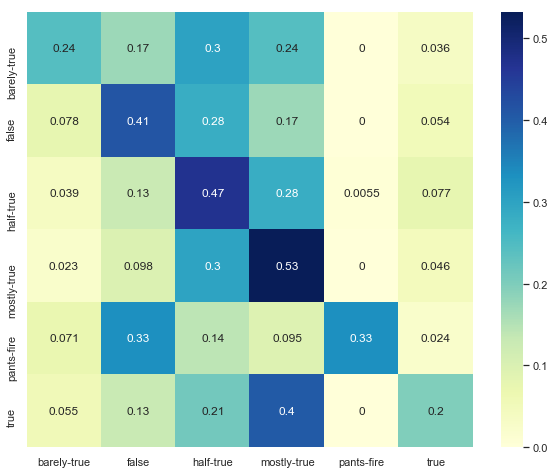

In [841]:
y_pred = clf_six_test.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average = 'micro'))
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
cm=metrics.confusion_matrix(y_test, y_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(cm, 
    xticklabels=clf_six_test.classes_,
    yticklabels=clf_six_test.classes_,
       annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

## Visualizing Results on Validation Dataset: Six Way Classification

Accuracy: 0.39789964994165694
Precision: 0.39789964994165694
              precision    recall  f1-score   support

 barely-true       0.57      0.28      0.38       153
       false       0.41      0.41      0.41       174
   half-true       0.33      0.53      0.40       173
 mostly-true       0.38      0.57      0.46       173
  pants-fire       1.00      0.17      0.29        60
        true       0.44      0.22      0.29       124

   micro avg       0.40      0.40      0.40       857
   macro avg       0.52      0.36      0.37       857
weighted avg       0.46      0.40      0.39       857

Confusion matrix:


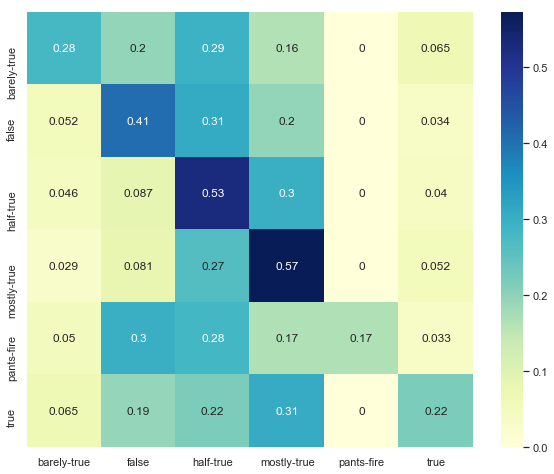

In [842]:
y_val_pred = clf_six_test.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, average = 'micro'))
print(classification_report(y_val, y_val_pred))
print('Confusion matrix:')
cm=metrics.confusion_matrix(y_val, y_val_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(cm, 
    xticklabels=clf_six_test.classes_,
    yticklabels=clf_six_test.classes_,
       annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

## Visualizing Results on Test Dataset: Binary Classification

Accuracy: 0.7205188679245284
Precision: 0.7205188679245284
              precision    recall  f1-score   support

       false       0.76      0.47      0.58       348
        true       0.71      0.90      0.79       500

   micro avg       0.72      0.72      0.72       848
   macro avg       0.73      0.68      0.68       848
weighted avg       0.73      0.72      0.70       848

Confusion matrix:


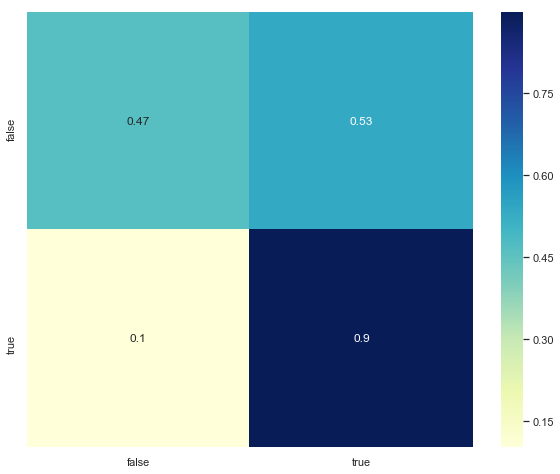

In [843]:
y_pred = clf_bin_test.predict(X_test)

print("Accuracy:", accuracy_score(y_bin_test, y_pred))
print("Precision:", precision_score(y_bin_test, y_pred, average = 'micro'))
print(classification_report(y_bin_test, y_pred))
print('Confusion matrix:')
cm=metrics.confusion_matrix(y_bin_test, y_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(cm, 
    xticklabels=clf_bin_test.classes_,
    yticklabels=clf_bin_test.classes_,
       annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

## Visualizing Results on Validation Dataset: Binary Classification

Accuracy: 0.6849474912485414
Precision: 0.6849474912485414
              precision    recall  f1-score   support

       false       0.76      0.44      0.56       387
        true       0.66      0.89      0.75       470

   micro avg       0.68      0.68      0.68       857
   macro avg       0.71      0.66      0.66       857
weighted avg       0.70      0.68      0.67       857

Confusion matrix:


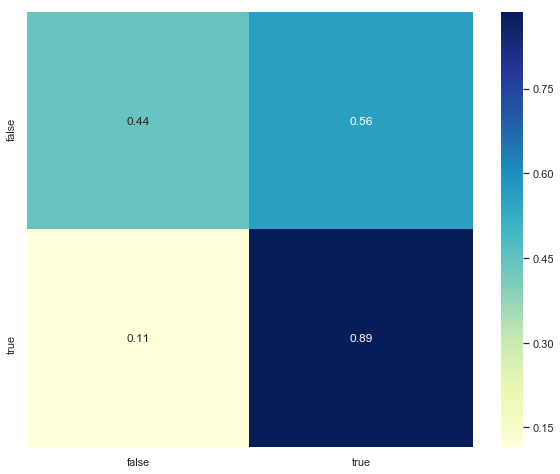

In [844]:
y_val_pred = clf_bin_test.predict(X_val)

print("Accuracy:", accuracy_score(y_bin_val, y_val_pred))
print("Precision:", precision_score(y_bin_val, y_val_pred, average = 'micro'))
print(classification_report(y_bin_val, y_val_pred))
print('Confusion matrix:')
cm=metrics.confusion_matrix(y_bin_val, y_val_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(cm, 
    xticklabels=clf_bin_test.classes_,
    yticklabels=clf_bin_test.classes_,
       annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

In [ ]:

# the inspiration behind this type of pipelinr system is drawn fro'https://www.kaggle.com/diveki/classification-with-nlp-xgboost-and-pipelines'
## This was the tuned XGBoost model which showed the highes accuracy